from : https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series


In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from numpy.random import normal, seed

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from pylab import rcParams

import seaborn as sns


from plotly import tools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import plotly.figure_factory as ff
init_notebook_mode(connected = True)

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


import scipy as sp
from scipy.stats import norm

import math

from sklearn.metrics import mean_squared_error


### DJIA 30 Stock Time Series:

Historical stock data for DJIA 30 companies (2006-01-01 to 2018-01-01)

DJIA = Dow Jones Industrial Average

https://www.kaggle.com/szrlee/stock-time-series-20050101-to-20171231


- one file contains all ("all_stocks")
- all files have columns s.t.:
    - date  in yy-mm-dd
    - open - price of stock at market open (USD)
    - high (highest price during day)
    - low close (lowest price during day)
    - volume (number shares traded)
    - name (stock's ticker name)


In [3]:
files_stocks = os.listdir("data/stocks")
print(os.listdir("data/stocks"))

['AABA_2006-01-01_to_2018-01-01.csv', 'AAPL_2006-01-01_to_2018-01-01.csv', 'all_stocks_2006-01-01_to_2018-01-01.csv', 'all_stocks_2017-01-01_to_2018-01-01.csv', 'AMZN_2006-01-01_to_2018-01-01.csv', 'AXP_2006-01-01_to_2018-01-01.csv', 'BA_2006-01-01_to_2018-01-01.csv', 'CAT_2006-01-01_to_2018-01-01.csv', 'CSCO_2006-01-01_to_2018-01-01.csv', 'CVX_2006-01-01_to_2018-01-01.csv', 'DIS_2006-01-01_to_2018-01-01.csv', 'GE_2006-01-01_to_2018-01-01.csv', 'GOOGL_2006-01-01_to_2018-01-01.csv', 'GS_2006-01-01_to_2018-01-01.csv', 'HD_2006-01-01_to_2018-01-01.csv', 'IBM_2006-01-01_to_2018-01-01.csv', 'INTC_2006-01-01_to_2018-01-01.csv', 'JNJ_2006-01-01_to_2018-01-01.csv', 'JPM_2006-01-01_to_2018-01-01.csv', 'KO_2006-01-01_to_2018-01-01.csv', 'MCD_2006-01-01_to_2018-01-01.csv', 'MMM_2006-01-01_to_2018-01-01.csv', 'MRK_2006-01-01_to_2018-01-01.csv', 'MSFT_2006-01-01_to_2018-01-01.csv', 'NKE_2006-01-01_to_2018-01-01.csv', 'PFE_2006-01-01_to_2018-01-01.csv', 'PG_2006-01-01_to_2018-01-01.csv', 'TRV_2006-0

In [47]:
AABA = pd.read_csv("data/stocks/"+files_stocks[0], parse_dates = ["Date"])
AABA.head(5)

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
1,2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA
2,2006-01-05,40.93,41.73,40.85,41.53,12829610,AABA
3,2006-01-06,42.88,43.57,42.80,43.21,29422828,AABA
4,2006-01-09,43.10,43.66,42.82,43.42,16268338,AABA


In [48]:
# look if missing values
assert(AABA.any().isnull().any() == False)
AABA.any().isnull()

# if na:
# AABA.fillna(method= "ffill")
# although for stocks: NO lol this is the whole point

Date      False
Open      False
High      False
Low       False
Close     False
Volume    False
Name      False
dtype: bool

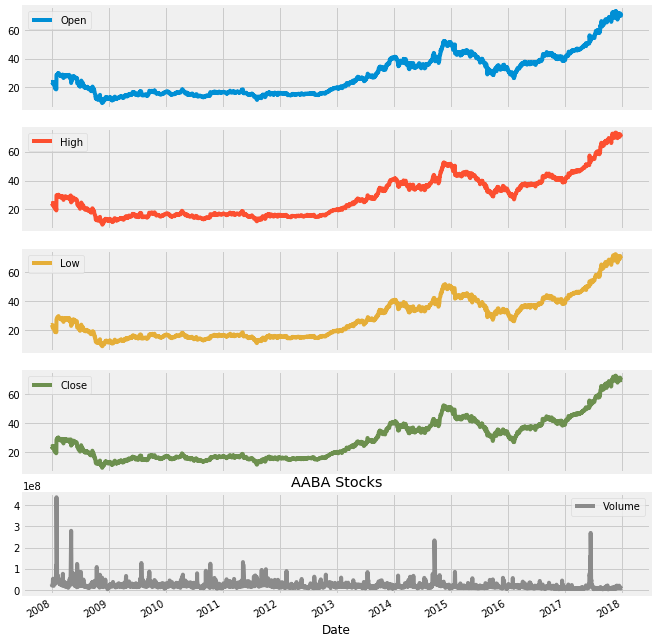

In [49]:
# should have two subplots; one for open high low close, the other one for volume
AABA.set_index("Date")["2008":"2018"].plot(subplots = True, figsize = (10,12))
plt.title("AABA Stocks")
# plt.savefig("AABA_stocks.png")
plt.show()

In [50]:
# timestamp = point in time
# period = interval in time
# date_range = returns a fixed frequency datetimeindex
pd.date_range(start='1/1/01', end='1/1/02', freq='M')
pd.date_range(start='1/1/01', end='1/1/02', periods = 12)


DatetimeIndex([          '2001-01-01 00:00:00',
               '2001-02-03 04:21:49.090909056',
               '2001-03-08 08:43:38.181818240',
               '2001-04-10 13:05:27.272727296',
               '2001-05-13 17:27:16.363636352',
               '2001-06-15 21:49:05.454545408',
               '2001-07-19 02:10:54.545454592',
               '2001-08-21 06:32:43.636363648',
               '2001-09-23 10:54:32.727272704',
               '2001-10-26 15:16:21.818181760',
               '2001-11-28 19:38:10.909090944',
                         '2002-01-01 00:00:00'],
              dtype='datetime64[ns]', freq=None)

In [51]:
AABA.Date = AABA.Date.apply(lambda x: pd.to_datetime(x))
# dont run this now

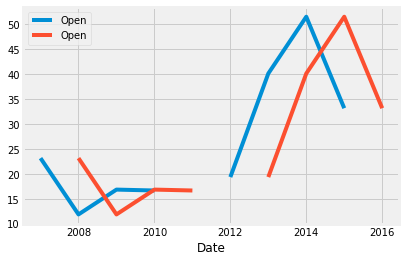

In [52]:
# visualize some early stuff
AABA.set_index("Date")["Open"].asfreq("Y").plot(legend = True)
shift = AABA.set_index("Date")["Open"].asfreq("Y").shift(1).plot(legend = True)
plt.show()
# as freq: M D Y or else, converst to frequency
# frequency here doesnt make much sense

In [53]:
# sampling
AABA_10d = AABA.set_index("Date").resample("10D").mean()
# downsampling to 10 day frequency aggregation using mean
AABA_1d = AABA_10d.resample("D").pad()
# upsampling back to norma;

In [54]:
print(AABA.shape, AABA_10d.shape, AABA_1d.shape)

(3019, 7) (438, 5) (4371, 5)


In [55]:
AABA = AABA.set_index("Date")
# should only be run once, top

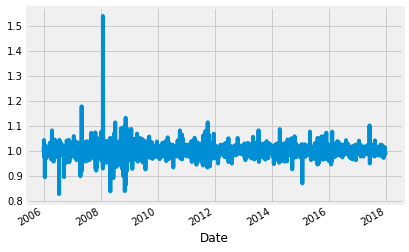

In [56]:
#  add some new columns
AABA["Change"] = AABA.High.div(AABA.High.shift())
AABA.Change.plot()
# div is division element wise
# shift is shifting time index 
# this gives you the percentage change!

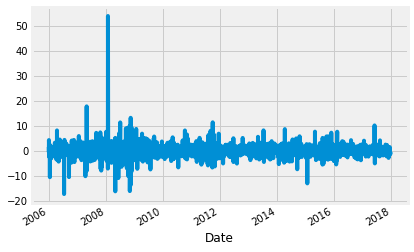

In [57]:
# sub subtracts element wise
# mul multiplies elemnt wise
AABA["Return"] = AABA.Change.sub(1).mul(100)
AABA.Return.plot()
#  is the same as
# AABA.High.pct_change().mul(100).plot()

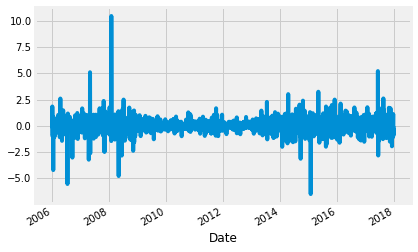

In [58]:
# difference from row to row (date to next date)
AABA.High.diff().plot()

In [59]:
AAPL = pd.read_csv("data/stocks/"+files_stocks[1], parse_dates = ["Date"])
AAPL.Date = AAPL.Date.apply(lambda x: pd.to_datetime(x))
AAPL.set_index("Date", inplace = True)

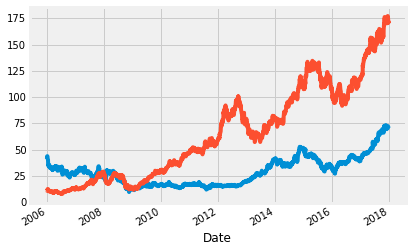

In [60]:
#  normalize with first value (--> increase comparison)
# should take stocks that have very different Highs but you get the point of this
AABA.High.plot()
AAPL.High.plot()

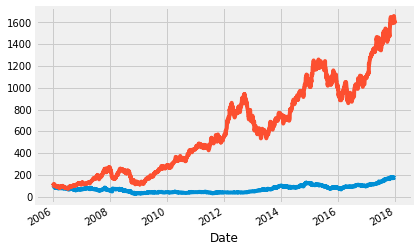

In [61]:
AABA_norm = AABA.High.div(AABA.High.iloc[0]).mul(100)
AAPL_norm = AAPL.High.div(AAPL.High.iloc[0]).mul(100)
AABA_norm.plot()
AAPL_norm.plot()
# percentage increase wrt 1st price(2006)

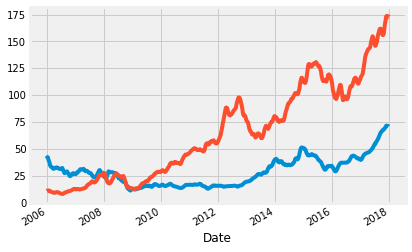

In [62]:
# what about increase over windows(less noise)
AABA_roll = AABA.High.rolling("30D").mean()
AAPL_roll = AAPL.High.rolling("30D").mean()
AABA_roll.plot()
AAPL_roll.plot()
# mean over 30D

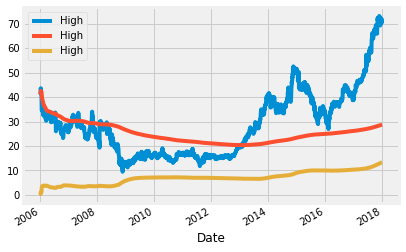

In [63]:
AABA_mean = AABA.High.expanding().mean()
AABA_std = AABA.High.expanding().std()
# expanding(number of row s to take into account for transformation).operation_for_transformation()
# expanding allows to add a row or other with a transformation
# = expanding transformations

AABA.High.plot()
AABA_mean.plot()
AABA_std.plot()
plt.legend()

In [64]:
# open high low close charts
AABA_ohlc_2008 = go.Ohlc(x= AABA["2008"].index,
                    open = AABA["2008"].Open,
                    high = AABA["2008"].High,
                    low = AABA["2008"].Low,
                    close = AABA["2008"].Close)
iplot([AABA_ohlc_2008])
#  high and low = length of line
# open and close; left tick = open, right tick = close
# red = bearish, the closing price is lower than opening
# green = bullish, the closing price is higher than opening


In [65]:
#  candlestick: open high low close too
AABA_candle_2008_march = go.Candlestick(x = AABA["2008-03"].index,
                            open = AABA["2008-03"].Open,
                            high = AABA["2008-03"].High,
                            low = AABA["2008-03"].Low,
                            close = AABA["2008-03"].Close)
iplot([AABA_candle_2008_march])

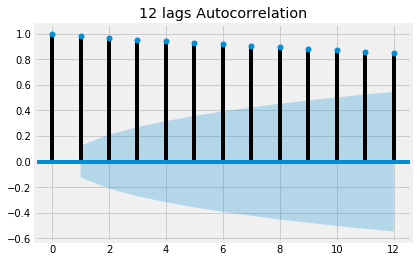

In [66]:
# Autocorrelation: series correlation wrt itself at different time lags
# partial correlation: regression of a series against its past lags. 
# --> the contribution of a change in that particular lag while holding others constant ^= 
# the partial autocorrelation coefficient
plot_acf(AABA["2008"].High, lags = 12, title = "12 lags Autocorrelation")
plt.show()
# not the best data to do this, we can see that as the correlation gets lowe rthe confidence interval gets much higher

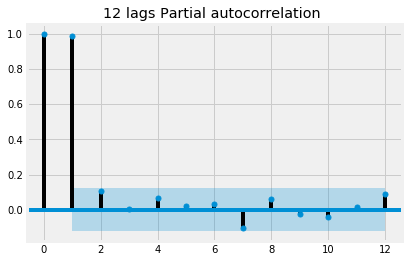

In [67]:
plot_pacf(AABA["2008"].High, lags = 12, title = "12 lags Partial autocorrelation ")
plt.show()
# here only the 2 first lags are statistically significant at level alpha (outside confidence interval)

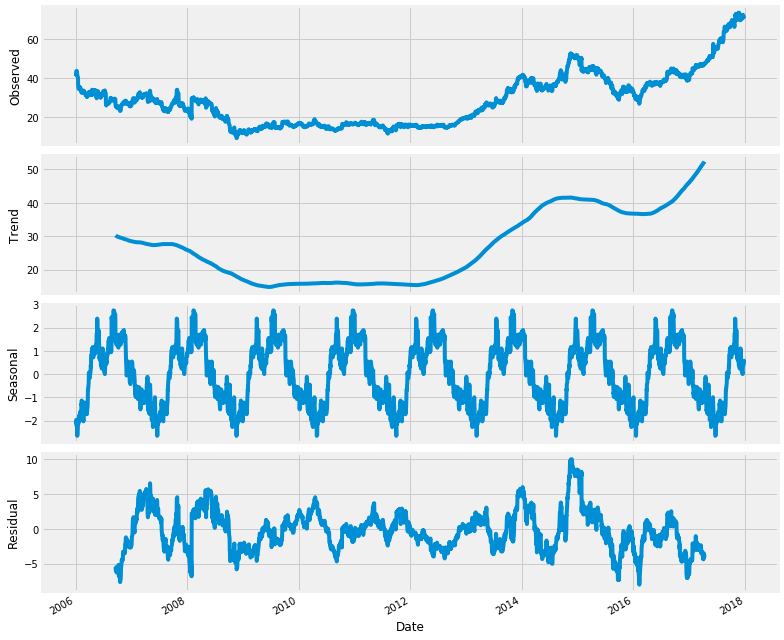

In [68]:
#  trend = consistent upwards  / downwards slope of time series
#  seasonality = clear periodic pattern of time series 
# noise = outliers, missing values
# Time series decompositions, random walks:
rcParams["figure.figsize"] = 11, 9
AABA_decomposed = sm.tsa.seasonal_decompose(AABA.High, freq = 360)
AABA_decomposed.plot()
plt.show()

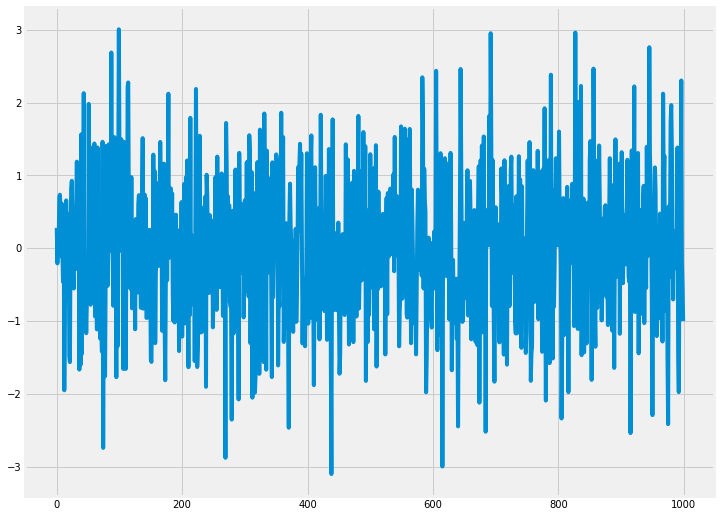

In [69]:
# white noise: constant mean and constant variance, zero auto correlation at any lag
white_noise = np.random.normal(loc=0, scale=1, size=1000)
plt.plot(white_noise)

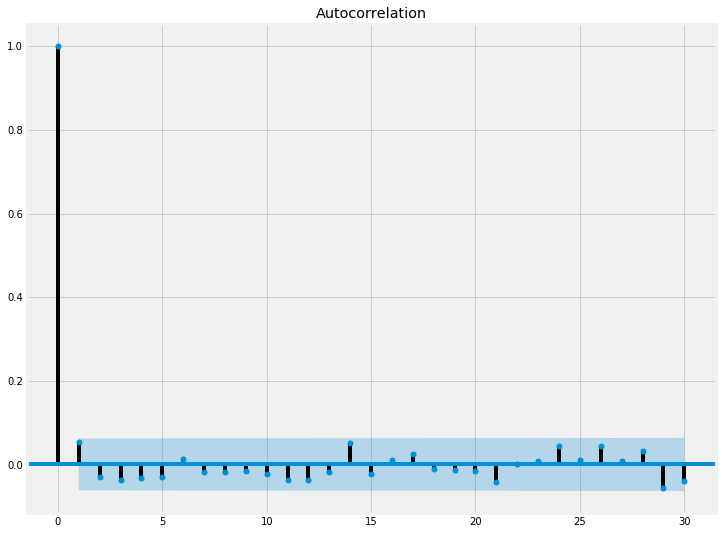

In [70]:
plot_acf(white_noise, lags = 30)
plt.show()

In [71]:
# random walk = stochastic process describin a path that consists of a succession of random steps
# on some mathematical space (e.g. integers)
# for stocks: today_price = yesterday_price + noise
# you can say for a drift mu, which is zero-meaned: price_today-price_yesterday = drift+noise
# hypothesis testing: regression test: price_today = alpha = beta*price_yesterday + noise
# H0 : beta =1, its a random walk
# H1: beat <1, its not a random walk
# for dickey fuller test, : H0:beta=0, its random walk; H1:beta<0, its not random walk
# augmented dickey fuller test: test null hypothesis that a unit root is present in a time series samples
adf = adfuller(AABA["Volume"])
adf
# since the pvalue is 1.01e-22 which is less than a level of condidence of alpha = 0.05, the null hypothesis is rejected at that confifdence level, so its not a random walk

(-12.23803209867337,
 1.0175158532174439e-22,
 7,
 3011,
 {'1%': -3.4325236578059055,
  '5%': -2.8625003821301203,
  '10%': -2.5672812364372812},
 107700.48414215069)

In [72]:
random_walk = normal(loc=0, scale = 0.01, size = 1000)
rw = ff.create_distplot([random_walk], ["Random Walk"], bin_size = 0.001)
iplot(rw)

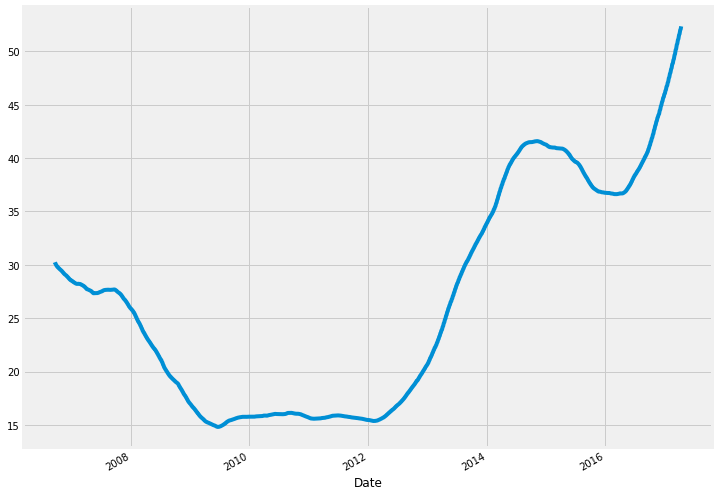

In [30]:
# stationarity: time series is stationary if its statistical properties are constant over tie
#  strong stationarity is a stochastic process whose unconditional joint probability distribution
# does not change when shifted in time. Therefore parameters such as mean and variance don't change with time either
# weak stationarity is a process where mean, variance, autocorrelation are constant throughout time.
# basically if your series is nonstationary, its tough to analyze
AABA_decomposed.trend.plot()

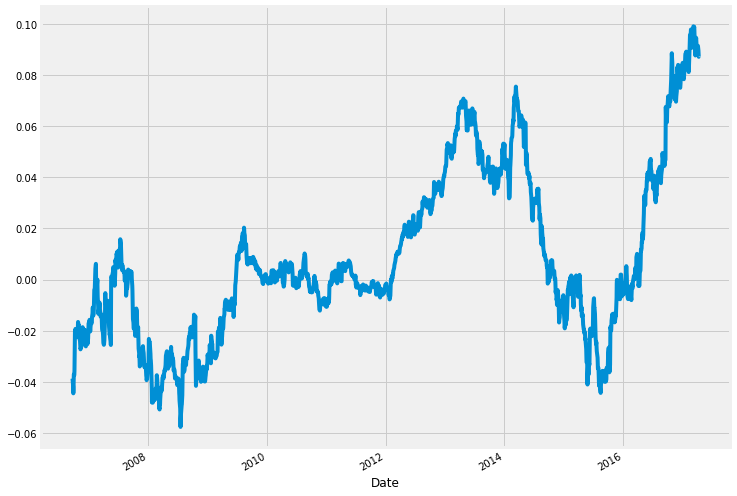

In [31]:
AABA_decomposed.trend.diff().plot()

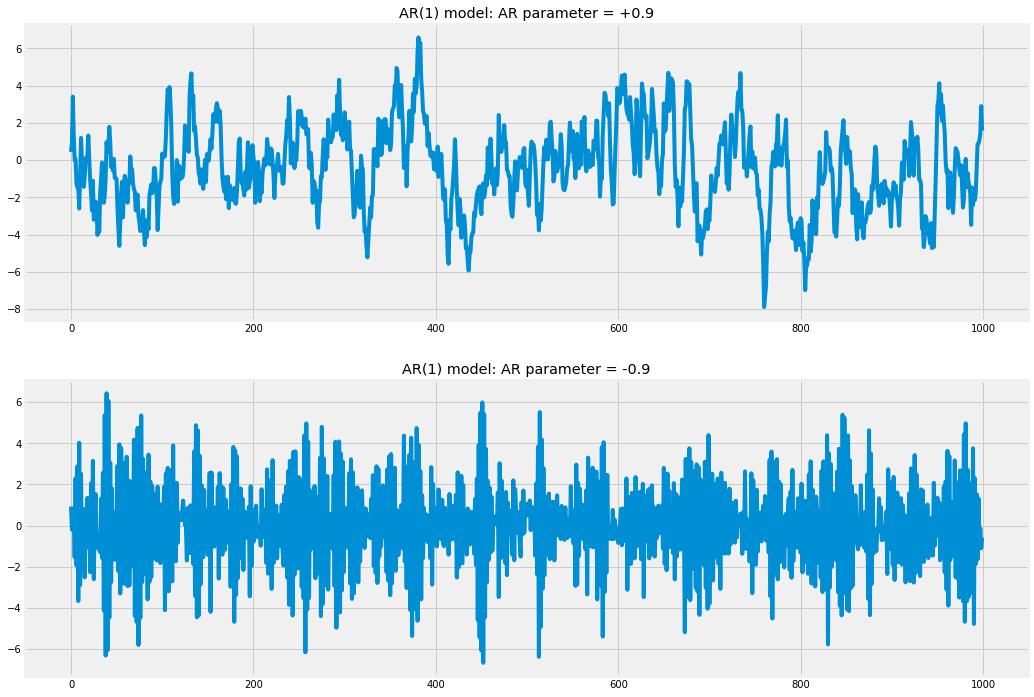

In [32]:
# AR models: autoregressive model is a representation of a type of random process. 
# used to describe certain time varying processes.
# The AR model specifies that the output variable depends linearly on its own previous values, and
#  on  a stochastic term . Its thus in the form of a stochastic difference equation
rcParams['figure.figsize'] = 16, 12
plt.subplot(2,1,1)
ar1 = np.array([1, -0.9]) # We choose -0.9 as AR parameter is +0.9
ma1 = np.array([1])
AR1 = ArmaProcess(ar1, ma1)
sim1 = AR1.generate_sample(nsample=1000)
plt.title('AR(1) model: AR parameter = +0.9')
plt.plot(sim1)
# We will take care of MA model later
# AR(1) MA(1) AR parameter = -0.9
plt.subplot(2,1,2)
ar2 = np.array([1, 0.9]) # We choose +0.9 as AR parameter is -0.9
ma2 = np.array([1])
AR2 = ArmaProcess(ar2, ma2)
sim2 = AR2.generate_sample(nsample=1000)
plt.title('AR(1) model: AR parameter = -0.9')
plt.plot(sim2)
plt.show()

# the models here: AR1: R  = mu + theta*R_previous + epsilon
# where epsilon = noise, this is orde r1. If theta = 1, its random walk, if =0 its white noise...
# if theta is between -1 and 1 it is stationary, if theta = -ve, there is mean reversion, if theta
#  is = +ve there is momentum
# AR2: R = mu = theta1*R_previous + theta2*R_previous + epsilon
# is order 2. 

In [33]:
model = ARMA(sim1, order = (1,0))
result = model.fit()
print(result.summary())
print("μ={} ,ϕ={}".format(result.params[0],result.params[1]))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(1, 0)   Log Likelihood               -1420.669
Method:                       css-mle   S.D. of innovations              1.001
Date:                Sun, 19 Apr 2020   AIC                           2847.338
Time:                        17:58:07   BIC                           2862.061
Sample:                             0   HQIC                          2852.934
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3893      0.294     -1.326      0.185      -0.965       0.186
ar.L1.y        0.8930      0.014     63.137      0.000       0.865       0.921
                                    Roots           

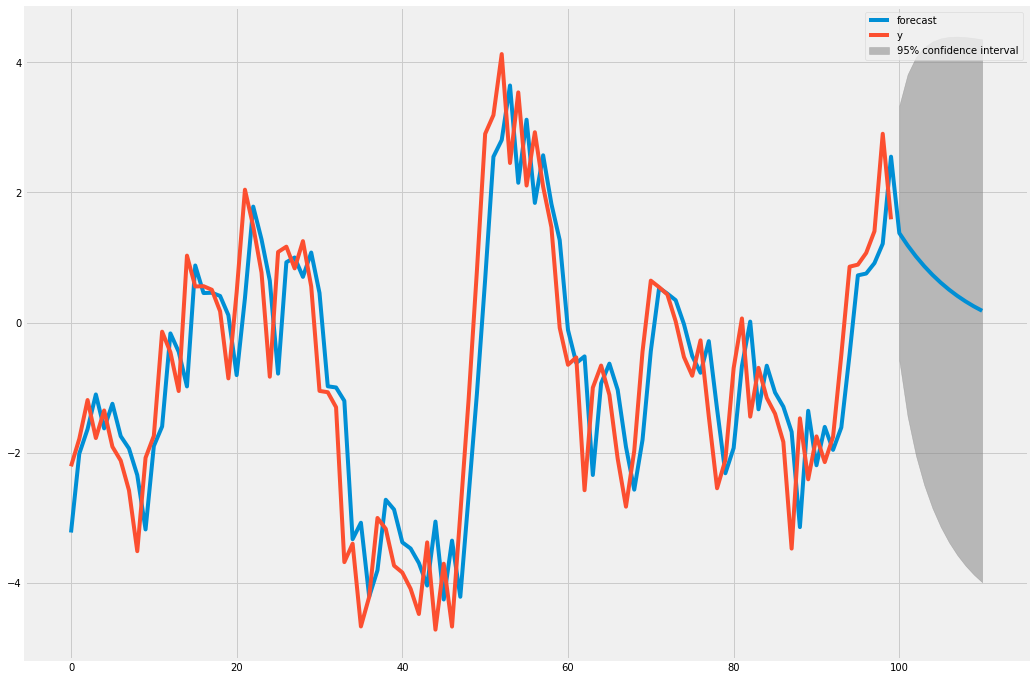

In [34]:
# we can predict the AR1 model
result.plot_predict(start = 900, end = 1010)
plt.show()

In [35]:
# and looking at rmse of predicted error:
rmse = math.sqrt(mean_squared_error(sim1[900:1011], result.predict(start=900, end=999)))
rmse

1.0068514933284782

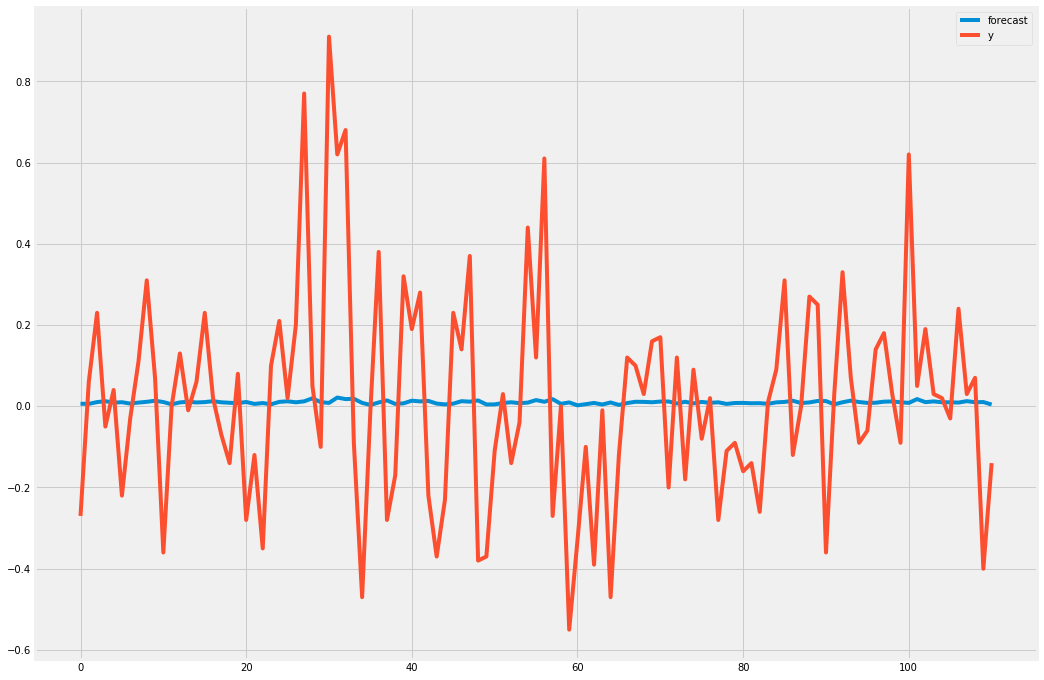

In [36]:
arma_AABA = ARMA(AABA["High"].diff().iloc[1:].values, order=(1,0))
res = arma_AABA.fit()
res.plot_predict(start = 900, end = 1010)
plt.show()

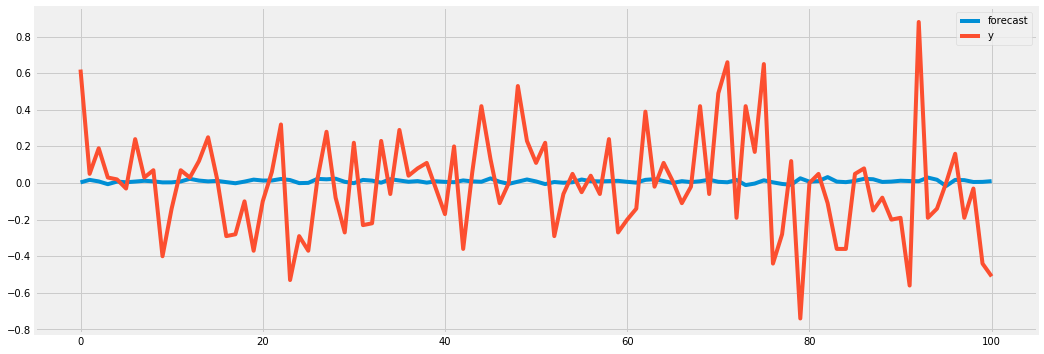

In [37]:
# moving average model: common approach for UNIVARIATE time series. the output variable depends lienarly on the current and past various values of a stochastic term
# only 1 lagged value in RHS --> MA model of order1
# the model is such that: R = mu = epsilon_today + epsilon_yesterday
rcParams["figure.figsize"]=16, 6
model = ARMA(AABA.High.diff().iloc[1:].values, order = (0,3))
result = model.fit()
result.plot_predict(start = 1000, end = 1100)
plt.show()

In [38]:
rmse = math.sqrt(mean_squared_error(AABA.High.diff().iloc[1000:1101].values, result.predict(start=1000, end = 1100)))
rmse

0.2708780026941801

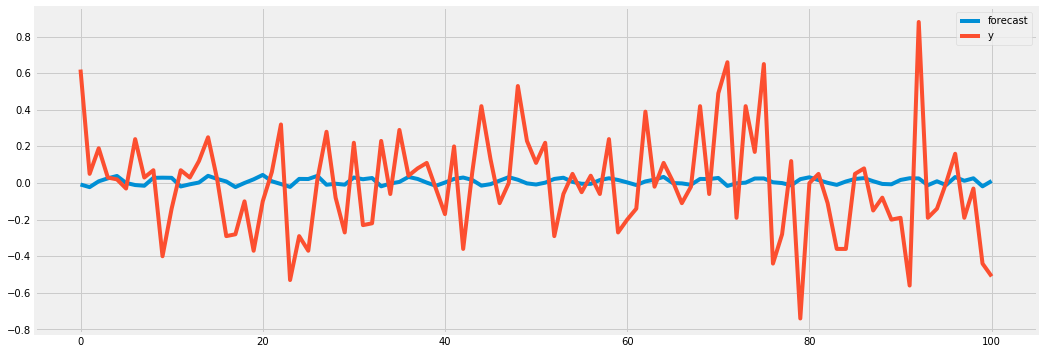

In [39]:
# ARMA: autoregressive moving average: provide description of a weakly stationary stochastic process
# in terms of two polynomials, one for AR and 2 for MA. fusion
# R_today = mu + R_yesterday + noise_today + noise_yesterday
rcParams["figure.figsize"]=16, 6
model = ARMA(AABA.High.diff().iloc[1:].values, order = (3,3))
result = model.fit()
result.plot_predict(start = 1000, end = 1100)
plt.show()

In [40]:
rmse = math.sqrt(mean_squared_error(AABA.High.diff().iloc[1000:1101].values, result.predict(start=1000, end = 1100)))
rmse

0.27829622025339035

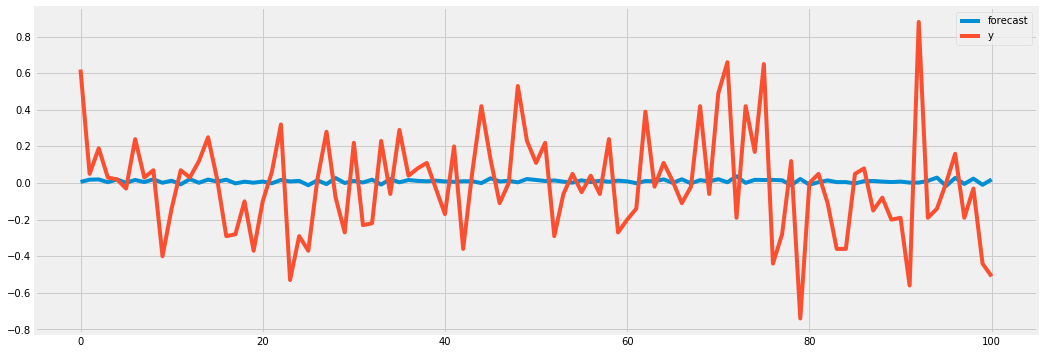

In [41]:
# ARIMA: generalization of ARMA. Both models are fitted to time sereies to predict or analyze
# ARIMA used when data is probably non-stationary: where an initial differencing step (integrated part of the model)
#  can be applied one or more times to eliminate the non-stationarity. ARIMA(p,d,q) with p = RA parameter
# d differential parameter, q MA parameter
rcParams["figure.figsize"]=16, 6
model = ARMA(AABA.High.diff().iloc[1:].values, order = (2,1,0))
result = model.fit()
result.plot_predict(start = 1000, end = 1100)
plt.show()

In [42]:
rmse = math.sqrt(mean_squared_error(AABA.High.diff().iloc[1000:1101].values, result.predict(start=1000, end = 1100)))
rmse

0.27047066910715617

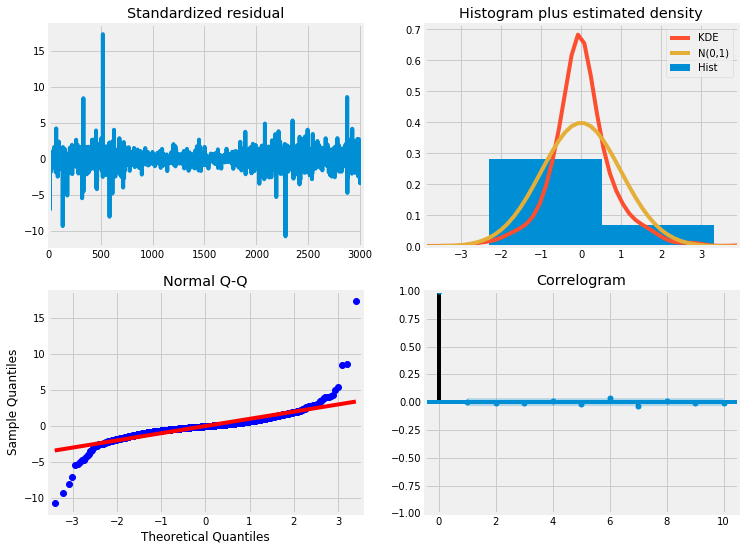

In [73]:
# VAR models: vector AR models: stochastic process model used to capture linear interdependencies among multiple time series
# VAR models generalize the univariate AR by allowing for more thatn one evolving variable.
# each model variable has an equation describing it wrt its own lagged values.
train_sample = pd.concat([AABA["High"].diff().iloc[1:], AAPL["High"].diff().iloc[1:]], axis = 1)
train_sample.columns = ["AABA","AAPL"]
model = sm.tsa.VARMAX(train_sample, order = (2,1), trend = "c")
result = model.fit(maxiter = 1000, disp = False)
predict = result.predict(start = 0, end = 1000)
result.plot_diagnostics()
plt.show()

In [74]:
rmse = math.sqrt(mean_squared_error(train_sample.iloc[1:1002].values, predict.values))
rmse

0.5780495149677303

In [4]:
# state space models: generalization of most time series models, flexible, works with estimations
# with missing observations, etc... very good. 

In [5]:
# SARIMA: good for seasonal! extension of ARIMA

https://www.kaggle.com/robikscube/time-series-forecasting-with-prophet/notebook

now looking at possible predictions!

- validation and training testing sets: cut off wrt time! 2010-2014 is training, 2014 on is validation , etc
    

In [6]:
AMZN = pd.read_csv("data/stocks/"+files_stocks[4], parse_dates = ["Date"])

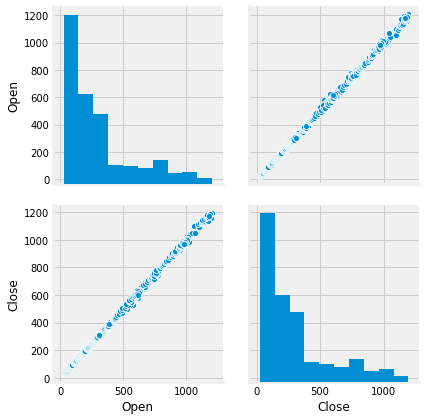

In [7]:
sns.pairplot(AMZN, height = 3, vars = ["Open","Close"], palette = "husl")
# pairplot doesn't make much sense here since our features day to day are too close...

In [9]:
import datetime as dt
# cant really predict anything with this information! just future stuff but meh.

In [57]:
AMZN.Date = AMZN.Date.apply(lambda x: pd.to_datetime(x))
AMZN["Year"]  = AMZN.Date.dt.year
AMZN["Month"]  = AMZN.Date.dt.month
AMZN["Day"]  = AMZN.Date.dt.day
AMZN["Day Of Week"] = AMZN.Date.dt.dayofweek

# bc Prophet wants it that way
AMZN["ds"]=AMZN.Date
AMZN["y"]=AMZN.High


In [58]:
print(AMZN.Year.min().min(), AMZN.Year.max().max())

2006 2017


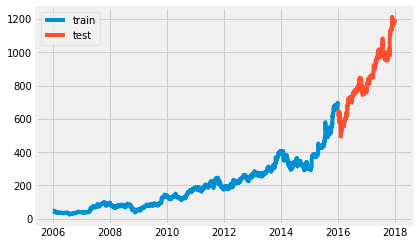

In [59]:
split_date = "01-Jan 2016"
AMZN_train = AMZN.loc[AMZN.Date <= split_date]
AMZN_test = AMZN.loc[AMZN.Date> split_date]
plt.plot(AMZN_train.Date, AMZN_train.High, label = "train")
plt.plot(AMZN_test.Date, AMZN_test.High, label = "test")
plt.legend(loc="best")
plt.show()

In [56]:
model = 

and this one for us energy stocks
https://www.kaggle.com/lislejoem/us_energy_census_gdp_10-14